### MNIST DATA 

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X,y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

- 70000 image instances 
- each image(row) has 28 x 28 = 784 features where each feature is pixel's intensity from 0(white) to 255(black)

In [4]:
X[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

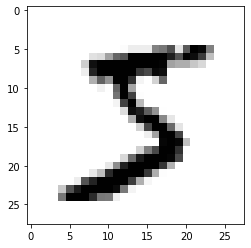

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

random_digit = X[0]
image = random_digit.reshape(28,28)

plt.imshow(image,cmap='binary')

In [6]:
y[0] #string

'5'

In [7]:
import numpy as np
y = y.astype(np.uint8)
y[0]

5

In [8]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:], y[:60000], y[60000:]

- Data is already shuffled properly. This gaurantees that every cross validation fold is similar
- Some algorithms are sensitive to recieve similar instances one after the other.

# 1. Binary Classifier

SGD (stochastic gradient descent) is good algorithm to start with
    - works well when data is large
    - trains every instance/row independently

In [9]:
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([random_digit])

array([ True])

# Performance Measures

### 1. Measure accuracy using cross validation

In [12]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
scores

array([0.95035, 0.96035, 0.9604 ])

96% accuracy looks good but lets compare it with a classifier that never classifies 5

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [14]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[   0, 5923],
       [   1, 6742],
       [   2, 5958],
       [   3, 6131],
       [   4, 5842],
       [   5, 5421],
       [   6, 5918],
       [   7, 6265],
       [   8, 5851],
       [   9, 5949]])

In [15]:
y_train.shape

(60000,)

In [16]:
5421/60000

0.09035

You still get a high  accuracy score. 

Thus accuracy is not a good measure of performance when your data is skewed. The images that are 5's make up for only 10% of this data set ie 90% of the time it classifies correctly.

### 2. Confusion matrix

In [17]:
from sklearn.model_selection import cross_val_predict

y_pred=cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_pred)

array([[53892,   687],
       [ 1891,  3530]])


              0 (neg)    1 (pos) 
  --------------------------------
    0 (neg)     TN          FP

    1 (pos)     FN          TP


### 3. Precision and Recall

    Precision = TP/(TP+FP)
    Recall / Sensitivity / TPR = TP/(TP+FN)

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_pred)

0.8370879772350012

#### If it claims the image is a 5, then the precision score tells us that it is correct 83.7% of the time

In [20]:
recall_score(y_train_5, y_pred)

0.6511713705958311

#### If it claims the image is a 5, then the recall score tells us that it is detecting only 65.1% of the 5's

#### F1 score

- Metric that is the harmonic mean of precision and recall. 
- While a normal mean weighs all points equally, harmonic mean gives more weight to the points with low values
- For F1 to be high, precision and recall both have to be high
- Useful in situations where precision and recall are similar

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_pred)

0.7325171197343846

- Classifying videos safe for kids - high precision 
- Classifying shoflifters in surveillance images - high recall

Generally, when precision increases, recall decreases and vice versa. 

SGD Classifier - scores every instance. if score is above threshhold then positive class else negative class.
Increasing the threshold -> increases the precision(bumpy) and reduces the recall(smooth)

* Sklearn doesnot allow you to set a threshhold but gives you descion scores using the functions

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

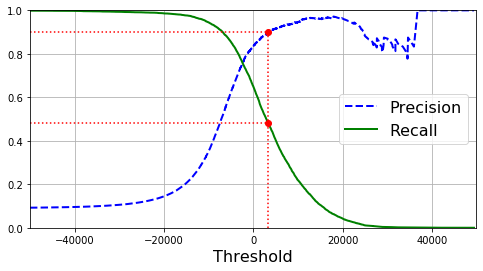

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                           # Not shown
plt.show()

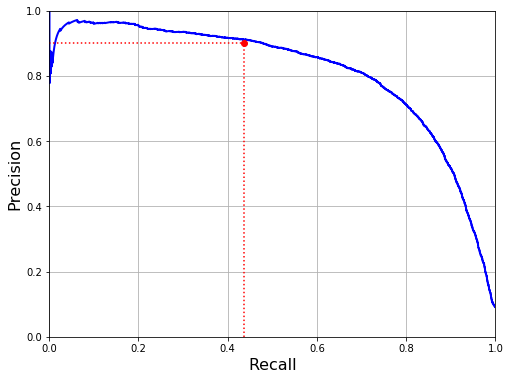

In [24]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
plt.show()

#### High precision does not mean a good classifier 

## 4. ROC curve

- similar to precision recall curve
- instead it plot, Recall/TRP/sensitivity against FPR/1-TNR/1-specificity

In [25]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds=roc_curve(y_train_5,y_scores)

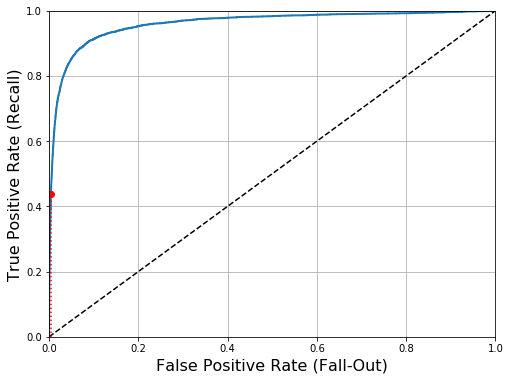

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

* Higher the recall more FP the model produces 

### How do i use this to compare different classifier? - AUC - area under the curve metrics
    - AUC = 0.5 for dotted line which represents a random classifier
    - AUC = 1 for a very good classifier
    - model that produces a line closer to the left top corner is the best.

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

## TRY all the above with random forest classifier

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [29]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [30]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [31]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

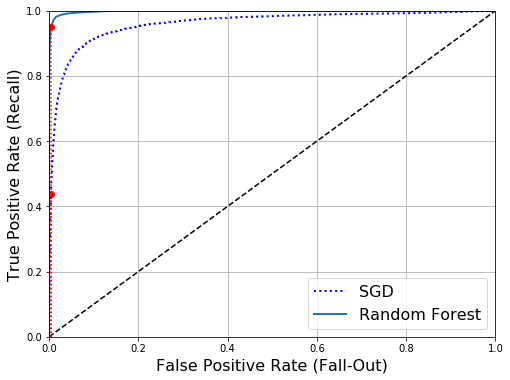

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [33]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

#### Random forest performs better

# 2. Multiclass / Multinomial classification

SGD / Random Forest / Naive Bayes- come with the inbuilt capability to perform binary as well as multiclass classification

However, suport vector machines and LogisticRegression can be used only for binary classification

Employ 2 strategies to perform multiclass using binary classifiers:

- one v/s rest or one v/s all
    1 and not one, 2 and not 2 ...... 10 and not 10. 
    To predict the class of a new instance: run all classifier, get decision scores from each and then choose the class based on the highest score
    
- one v/s one 
    1 or 2, 1 or 3, 1 or 4,..., 2 or 3....
    you need N*(N-1)/2 classifiers
    

In [34]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([random_digit])

array([5], dtype=uint8)

In [35]:
random_digit_scores = svm_clf.decision_function([random_digit])
random_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [36]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [37]:
np.argmax(random_digit_scores)

5

Here the SCV internally ran a OVO strategy and correctly identified a 5 

This can be done explicitly using the OneVsRestClassifier of sklearn

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([random_digit])

array([5], dtype=uint8)

In [39]:
len(ovr_clf.estimators_)

10

Similarly, running an sgd to perform multiclass

In [40]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([random_digit])

array([3], dtype=uint8)

In [41]:
sgd_clf.decision_function([random_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [42]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

Standard scalar

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/Users/shivaniramdas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

# 3. Error Analysis

In [44]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

/Users/shivaniramdas/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]])

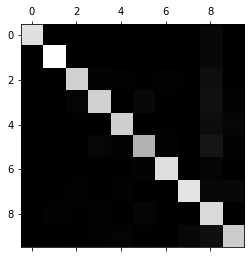

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

- The main diagonal is bright and everything else dark means that classes are being labelled correctly. 
- 5 looks darker than the rest on the diagonal meaning that either 5 are less in the entire data or classifier doesnot perform well with 5's

So instead, we plot the graph in a way we can visualise the error rate per class

In [46]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

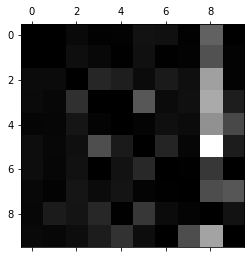

In [47]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Looking at the column of 8 we can say that many images are getting falsely classified as 8. But looking at the row for 8 we see that 8's are being classified correctly. How to solve these errors by reducing these false 8's:
    - collect more data that looks like 8 but is not
    - add more features that calculate the loops in the digits to enhance the classification
    - Use sklearns libraries: Sk-image, openCV, pillow to make some patterns (like loops) stand out more
    - Preprocess to ensure images are centered and not rotated

# 4. Multilabel classification

You want to predict not just one but many target vlaues

Example: Image recognition where one image can have many faces and we want all those to be tagged
    
    Image 1 : [1,0,1] if the taget faces are [Alice, Bob, Charlie]

In [48]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
knn_clf.predict([random_digit])

array([[False,  True]])

Evaluation using F1 score

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Here it assumes that all labels are equally important but in cases where images of Alice may be more than others we want the classifier to weigh these images more. Like in this case the images of 5 are very few. 

In [52]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

# 5. Multioutput classification - Cleaning images 

- Multilabel where every label has multiple values
- In this example: every pixel of the noisy image is a label and each label takes values 0-255 (ie pixel intensity)
- output : clean image like those in MNIST dataset

In [53]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [55]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

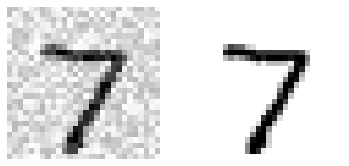

In [56]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

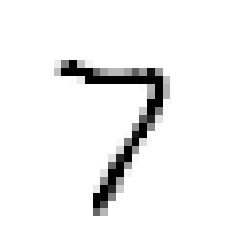

In [58]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)